In [1]:
import torch
import cv2
import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
from tqdm.auto import tqdm
from torchvision.datasets import VOCSegmentation

# Get PASCAL VOC 2012 Segmentation data

data_path = '../../Data'

ds_train = VOCSegmentation(root=data_path, year='2012', image_set='train', download=False)
ds_valid = VOCSegmentation(root=data_path, year='2012', image_set='val', download=False)

print(f'num of train : {len(ds_train)} || num of valid : {len(ds_valid)}')

num of train : 1464 || num of valid : 1449


/home/kdb/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


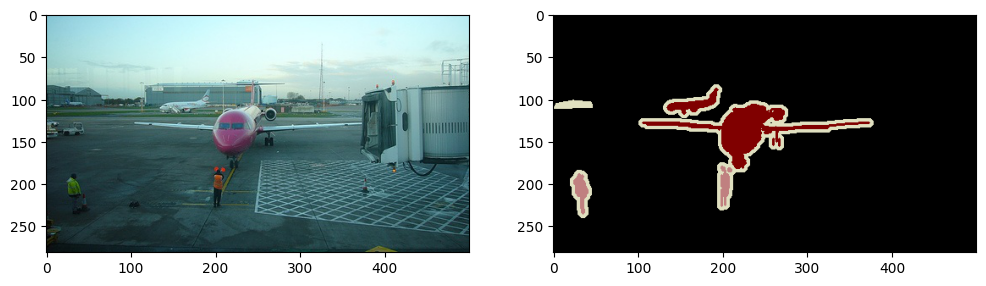

In [2]:
# Check train dataset
img, lbl = ds_train.__getitem__(0)

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(lbl)
plt.show()

lbl.save('test_image_0.png')

In [3]:
new_lbl = Image.open('test_image_0.png')
new_lbl = np.array(new_lbl)

print(f' mask image shape : {new_lbl.shape}')
np.unique(new_lbl)

 mask image shape : (281, 500)


array([  0,   1,  15, 255], dtype=uint8)

In [4]:
ds_list = [ds_train, ds_valid]
data_save_path = '../../Data/VOCseg'

for ds in ds_list:
    if ds == ds_train:
        img_save_path = data_save_path + '/train/image'
        lbl_save_path = data_save_path + '/train/label'
    else:
        img_save_path = data_save_path + '/valid/image'
        lbl_save_path = data_save_path + '/valid/label'

    if os.path.exists(img_save_path) and os.path.exists(lbl_save_path):
        pass
    else:
        os.makedirs(img_save_path)
        os.makedirs(lbl_save_path)
    
    for i in tqdm(range(len(ds)), total=len(ds)):
        img, lbl = ds.__getitem__(i)
        img.save(img_save_path + f'/image_{i}.jpg')
        lbl.save(lbl_save_path + f'/image_{i}.png')
    

100%|██████████| 1449/1449 [00:08<00:00, 176.10it/s]


In [5]:
import torch
from tqdm import tqdm
from Dataset import _VOCdataset
import torchvision.transforms.functional as F

# 데이터셋을 초기화합니다.
ds_train = _VOCdataset(mode='train')
ds_valid = _VOCdataset(mode='valid')

def calculate_mean_std(ds):
    sum_rgb = torch.tensor([0.0, 0.0, 0.0])
    sum_rgb_squared = torch.tensor([0.0, 0.0, 0.0])
    n_pixels = 0
    
    for i in tqdm(range(len(ds)), desc="Calculating mean and std"):
        sample = ds.__getitem__(i)
        img = sample['image']
        img = F.resize(img, (224,224))
        sum_rgb += img.float().sum(dim=[1,2])
        sum_rgb_squared += (img.float() ** 2).sum(dim=[1,2])
        n_pixels += img.shape[1] * img.shape[2]
    
    mean = sum_rgb / n_pixels
    std = (sum_rgb_squared / n_pixels - mean ** 2) ** 0.5
    return mean, std

mean_train, std_train = calculate_mean_std(ds_train)
mean_valid, std_valid = calculate_mean_std(ds_valid)

print(f"Training set mean: {mean_train}, std: {std_train}")
print(f"Validation set mean: {mean_valid}, std: {std_valid}")


Calculating mean and std: 100%|██████████| 1449/1449 [00:02<00:00, 535.71it/s]

Training set mean: tensor([0.4567, 0.4425, 0.4077]), std: tensor([0.2722, 0.2690, 0.2843])
Validation set mean: tensor([0.4565, 0.4383, 0.4010]), std: tensor([0.2688, 0.2672, 0.2830])


In [6]:
ds_list = [('train', ds_train), ('valid', ds_valid)]

class_pixel_counts = {'train': {}, 'valid': {}}

for mode, ds in ds_list:
    total_class = class_pixel_counts[mode]
    for i in tqdm(range(len(ds)), desc=f"Processing {mode} dataset"):
        sample = ds.__getitem__(i)
        img, lbl = sample['image'], sample['label']
        uniqs, counts = torch.unique(lbl, return_counts=True)
        _uniq = torch.unique(img)

        for cls, count in zip(uniqs, counts):
            cls = cls.item()
            if cls not in total_class:
                total_class[cls] = count.item()
            else:
                total_class[cls] += count.item()

Processing valid dataset: 100%|██████████| 1449/1449 [00:08<00:00, 175.30it/s]


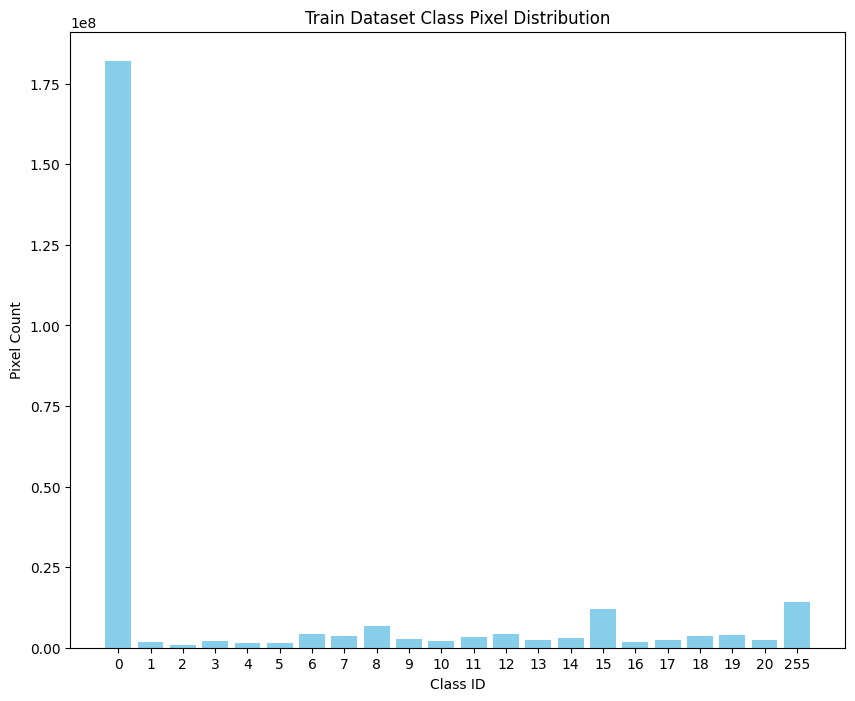

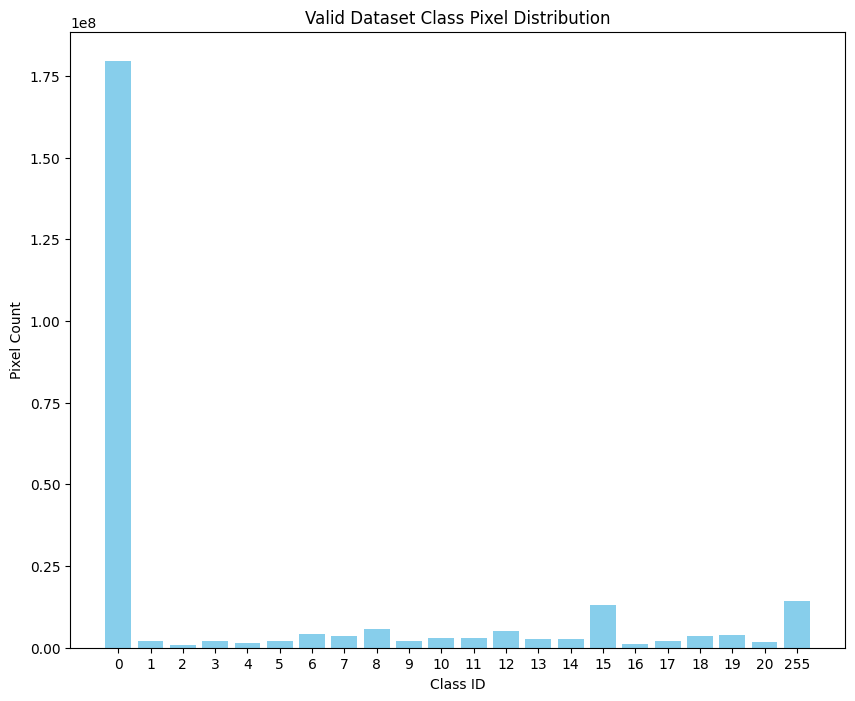

In [7]:
import matplotlib.pyplot as plt

def plot_class_distributions(class_pixel_counts, title):
    classes = list(range(21)) + [255]  
    pixel_counts = [class_pixel_counts.get(cls, 0) for cls in classes]  
    x_pos = list(range(21)) + [21]  
    
    plt.figure(figsize=(10, 8))  
    plt.bar(x_pos, pixel_counts, color='skyblue', tick_label=classes)  
    plt.xlabel('Class ID')
    plt.ylabel('Pixel Count')
    plt.title(title)
    plt.xticks(x_pos, classes) 
    plt.show()

plot_class_distributions(class_pixel_counts['train'], 'Train Dataset Class Pixel Distribution')
plot_class_distributions(class_pixel_counts['valid'], 'Valid Dataset Class Pixel Distribution')
